# VariableImportance.ipynb

#!/usr/bin/env python

    File name: VariableImportance.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.04.2018
    Date last modified: 19.04.2018

    ############################################################## 
    Purpos:
    Investigate which variables were most frequently picked in settings with good performance.
    
    This requires to first run:
    ~/papers/Extreme-WTs-US/programs/Extreme-WTs/SearchOptimum_XWT-Combination.py

    1) read in the preprocessed files

    2) grep the best perfroming settings

    3) calculate the frequency of variables and plot them for each watershed


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn

### Setup

In [2]:
sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/VariableImportance/'
sDataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
DW_Regions=['1501','1502','1503','1504','1505','1506','1507','1810','HUC6-00','HUC6-01','HUC6-02','HUC6-03','HUC6-04','HUC6-05']
sRegNames=['1501','1502','1503','1504','1505','1506','1507','1810', '130100','130201','130202','130600','130301','140801']
sMonths='6-7-8-9-10'
YYYY_stamp='1982-2018'
rgsWTvars=['PSL','U850','V850','UV850', 'MFL850',  'MFL500', 'Q850', 'Q500', 'ZG500', 'UV200','T850','T500']

PercVarSel=10

# SelVar = np.array([['PW','MFL850','ZG500'],
#  ['MFL850','CAPE','UV200'],
#  ['U850','V850','MFL500'],
#  ['U850','PW','ZG500'],
#  ['PW','Q500','UV200'],
#  ['UV850','PW','Q500'],
#  ['Q500','UV200'],
#  ['UV850','ZG500'],
#  ['UV850','Q850','Q500'],
#  ['PW','ZG500'],
#  ['Q850','ZG500'],
#  ['MFL850','Q500','ZG500'],
#  ['PW','MFL500','ZG500'],
#  ['V850','PW','MFL500'],
#  ['V850','PW','Q500'],
#  ['PSL','PW','Q850'],
#  ['PSL','MFL850'],
#  ['PSL','PW','MFL850']])

### Load the data and perform the variance decomposition

In [3]:
ANOVA_All=np.zeros((10,2,len(DW_Regions))); ANOVA_All[:]=np.nan
for re in range(len(DW_Regions)):
    sRegion=DW_Regions[re]
    sRegion=sRegion.replace('/','-')
    SaveStats=sDataDir+sRegion+'_'+YYYY_stamp+'-'+sMonths+'.npz'
    try:
        DATA=np.load(SaveStats, allow_pickle=True)
    except:
        print('    Missing: '+SaveStats)
        continue
    SkillScores_All=DATA['SkillScores_All']
    Combinations=DATA['Combinations']
    VarsFullName=DATA['rgsWTvars']
    rgrNrOfExtremes=DATA['rgrNrOfExtremes']
    WT_Domains=DATA['WT_Domains']
    Annual_Cycle=DATA['Annual_Cycle']
    SpatialSmoothing=DATA['SpatialSmoothing']
    Metrics=DATA['Metrics']
    Dimensions=DATA['Dimensions']
    AUC = SkillScores_All[:,:,:,:,:,2,list(Metrics).index('PRanom')]
    APR = SkillScores_All[:,:,:,:,:,2,list(Metrics).index('InterVSIntra')]
    SkillScores = (AUC+APR)/2 #(AUC+PSS)/2
#     SkillScores = np.mean(SkillScores, axis=5)
    

    TH=np.nanpercentile(SkillScores,100-PercVarSel)
    iPickCount = np.nansum((SkillScores >= TH), axis=(1,2,3,4))
    if re == 0:
        Variables=np.zeros((len(DW_Regions),len(VarsFullName)))
    for ii in range(len(iPickCount)):
        if iPickCount[ii] > 0:
            Var=Combinations[ii]
            for jj in range(len(Var)):
                Variables[re,Var[jj]]=Variables[re,Var[jj]]+1
Variables=(Variables/np.nansum(Variables, axis=1)[:,None])*100

In [4]:
SkillScores_All.shape

(298, 1, 3, 1, 1, 3, 8)

In [5]:
np.where(np.array([(Combinations[ii] == np.array([7]))[0] for ii in range(len(Combinations))]) == True)

(array([  7,  68,  69,  70,  71, 288, 289, 290, 291, 292, 293]),)

In [6]:
np.where(np.array([np.sum(Combinations[ii] == np.array([1,5,10])) for ii in range(len(Combinations))]) == 3)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([161]),)

In [7]:
Combinations[55]

array([ 4, 10])

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/VariableImportance/VariableImportance_HandK.pdf


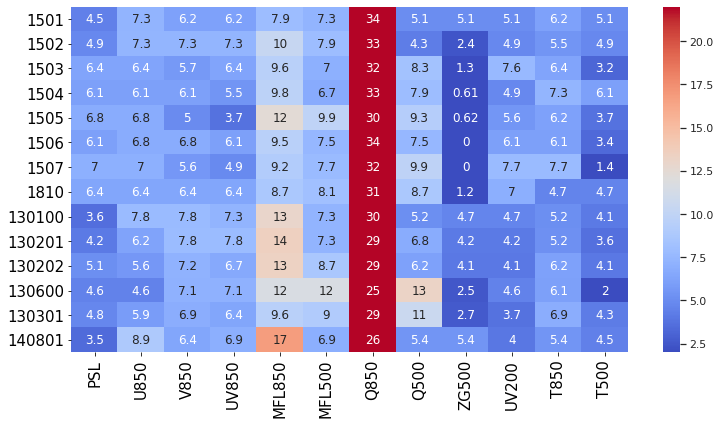

In [8]:
SortedVars=['PSL','U850','V850','UV850',  'MFL850',  'MFL500', 'Q850', 'Q500', 'ZG500', 'UV200','T850','T500']
iVarSort=[list(VarsFullName).index(SortedVars[va]) for va in range(len(SortedVars))]
Variables=(Variables/np.sum(Variables, axis=1)[:,None])*100

plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(14,10))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.30, right=0.99,
           bottom=0.50, top=0.98,
           wspace=0.35, hspace=0.20)
ax = plt.subplot(gs1[0,0])

import seaborn as sns; sns.set()
ax=sns.heatmap(Variables[:,iVarSort], cmap='coolwarm', vmin=2, vmax=22, annot = True) #,
                             #cbar_kws={'label': 'variable selection frequency [%]', "orientation": "horizontal"}) # cmap='YlGnBu'
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(SortedVars, rotation=90)

ax.set_label('your label here')

sPlotFile=sPlotDir
sPlotName= 'VariableImportance_HandK.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [9]:
ii=0
for re in range(len(DW_Regions)):
    sRegion=DW_Regions[re]
    sRegion=sRegion.replace('/','-')
    SaveStats=sDataDir+sRegion+'_'+YYYY_stamp+'-'+sMonths+'.npz'
    if os.path.exists(SaveStats) == True:
        DATA=np.load(SaveStats, allow_pickle=True)
        SkillScores_All=DATA['SkillScores_All']
        Combinations=DATA['Combinations']
        VarsFullName=DATA['rgsWTvars']
        rgrNrOfExtremes=DATA['rgrNrOfExtremes']
        WT_Domains=DATA['WT_Domains']
        Annual_Cycle=DATA['Annual_Cycle']
        SpatialSmoothing=DATA['SpatialSmoothing']
        Metrics=DATA['Metrics']
        Dimensions=DATA['Dimensions']
        
        VARS=np.copy(VarsFullName)
        
#         SkillScores_All[np.isnan(SkillScores_All)]=1

        AUC = SkillScores_All[:,:,:,:,:,2,list(Metrics).index('PRanom')]
        APR = SkillScores_All[:,:,:,:,:,2,list(Metrics).index('InterVSIntra')]
        SkillScores = (AUC+APR)/2 #(AUC+PSS)/2
#         SkillScores=(1-np.abs((SkillScores_All[:,:,:,:,:,:,list(Metrics).index('AUC')])-0.5)*2+(1-SkillScores_All[:,:,:,:,:,:,list(Metrics).index('APR')]))/2.
#         SkillScores = np.mean(SkillScores, axis=(5))
        if ii == 0:
            ANOVA_All=np.zeros((10,2,len(DW_Regions))); ANOVA_All[:]=np.nan
#             Variables=np.zeros((len(DW_Regions),len(VarsFullName)))
            AllSS=np.zeros((len(DW_Regions),len(SkillScores))); AllSS[:]=np.nan
        AllSS[re,:]=np.nanmean(np.squeeze(SkillScores),axis=(1))
        
#         TH=np.nanpercentile(SkillScores,PercVarSel)
#         ScoresSel=SkillScores[(SkillScores < TH)]
#         for ii in range(len(ScoresSel)):
#             Location=np.where(SkillScores == ScoresSel[ii])
#             Var=Combinations[Location[0][0]]
#             for jj in range(len(Var)):
#                 Variables[re,Var[jj]]=Variables[re,Var[jj]]+1
                
        # store the best performing settings
        ev=100
        AUC = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('PRanom')]
        APR = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('InterVSIntra')]
        Scores = (AUC+APR)/2
        Mean_SS=np.nanmean(Scores, axis=(5))
        TopScores = np.sort(Mean_SS.flatten())[-ev:]
        VARS=list(['test'])
        for sc in range(ev):
            iOpt=np.where(TopScores[sc] == Mean_SS)
            if len(iOpt[0]) != 0:
                if (VarsFullName[Combinations[iOpt[0][0]]].shape != ()):
                    VARS1 = VARS.append('-'.join(list(VarsFullName[Combinations[iOpt[0][0]]]))+', '+str(rgrNrOfExtremes[iOpt[1][0]])+', '+str(WT_Domains[iOpt[2][0]])+', '+str(SpatialSmoothing[iOpt[3][0]])+', '+str(np.round(TopScores[sc],2)))
                else:
                    VARS1 = VARS.append(VarsFullName[Combinations[iOpt[0][0]]])
            else:
                VARS1 = None
        VARS = VARS[1:]
        pd.DataFrame(VARS).to_csv(sDataDir+'BestSettings/'+DW_Regions[re].replace('/','-')+"_top-"+str(ev)+"-vars.csv",header=False)
        
        # store the variable selection ranking
        iVarSort=VarsFullName[np.argsort(Variables[re,:])][::-1]
        JoinedVars=','.join(iVarSort)
        pd.DataFrame([JoinedVars]).to_csv(sDataDir+'BestSettings/'+DW_Regions[re].replace('/','-')+"_VariableRanking.csv",header=False, index=False)
        ii = ii+1
    else:
        print('    Missing: '+SaveStats)
        pass

In [10]:
sDataDir+'BestSettings/'

'/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/BestSettings/'

In [11]:
sDataDirNE=sDataDir
ii=0
for re in range(len(DW_Regions)):
    sRegion=DW_Regions[re]
    sRegion=sRegion.replace('/','-')
    SaveStats=sDataDirNE+sRegion+'_'+YYYY_stamp+'-'+sMonths+'.npz'
    if os.path.exists(SaveStats) == True:
        DATANE=np.load(SaveStats, allow_pickle=True)
        SkillScores_All=DATANE['SkillScores_All']
        rgrNrOfExtremes=DATANE['rgrNrOfExtremes']
        VARS=np.copy(VarsFullName)
        AUC = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('PRanom')]
        APR = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('InterVSIntra')]
        SkillScores = (AUC+APR)/2 #(AUC+PSS)/2
        if ii == 0:
            Extremes=np.zeros((len(DW_Regions),len(rgrNrOfExtremes)))
            AllSSNE=np.zeros((len(DW_Regions),SkillScores.shape[0],SkillScores.shape[1])); AllSSNE[:]=np.nan
        AllSSNE[re,:,:]=np.nanmean(SkillScores,axis=(2,3,4,5))
    else:
        print('    Missing: '+SaveStats)
        pass
    ii = ii+1

In [12]:
AllSSNE.shape

(14, 298, 1)

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/VariableImportance/VariableImportance_HandK_NEW.pdf


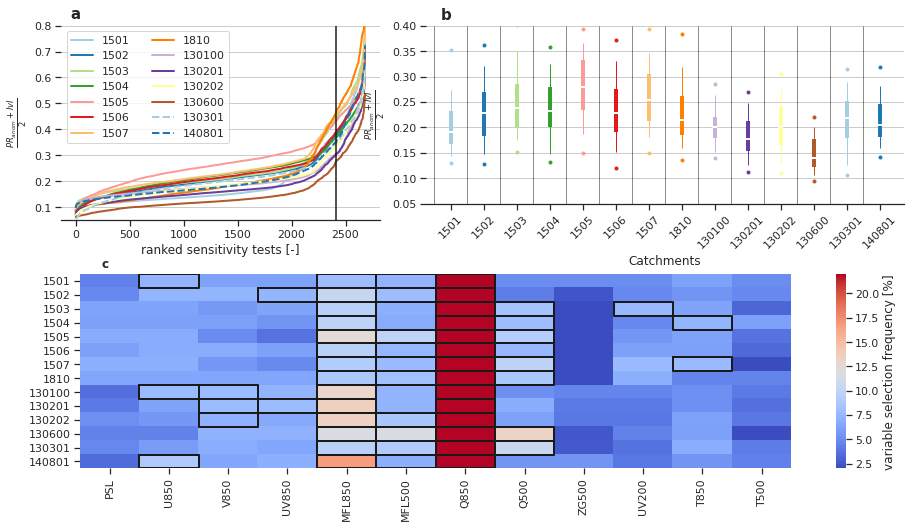

In [18]:
iVarSort=[list(VarsFullName).index(SortedVars[va]) for va in range(len(SortedVars))]
# Variables=(Variables/np.sum(Variables, axis=1)[:,None])*100
seaborn.set_style('ticks')# ax2.grid()

rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(13,7.5))
plt.rcParams.update({'font.size': 15})

#####################################################
# show skill as function of var. perturbation
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.08, right=0.42,
           bottom=0.6, top=0.96,
           wspace=0.4, hspace=0.20)
ax2 = plt.subplot(gs2[0,0])
COLORS=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928',\
        '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
LineStyle=['-','-','-','-','-','-','-','-','-','-','-','-',\
        '--','--','--','--','--','--','--','--','--','--','--','--']
for re in range(len(DW_Regions)):
    sRegion=DW_Regions[re]
    sRegion=sRegion.replace('/','-')
    
    SaveStats=sDataDir+sRegion+'_'+YYYY_stamp+'-'+sMonths+'.npz'
    try:
        DATA=np.load(SaveStats, allow_pickle=True)
    except:
        print('    Missing: '+SaveStats)
        continue
    SkillScores_All=DATA['SkillScores_All']
    VARS=np.copy(VarsFullName)
    AUC = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('PRanom')]
    APR = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('InterVSIntra')]
    SkillScoresTMP = (AUC+APR)/2 #(AUC+PSS)/2
    ax2.plot(np.abs(np.sort(SkillScoresTMP.flatten())), c=COLORS[re], lw=2, label=sRegNames[re],ls=LineStyle[re])
    
#     ax2.plot(np.abs(np.sort(AllSS[re,:])[::-1]-1), c=COLORS[re], lw=2, label=sRegNames[re],ls=LineStyle[re])
plt.legend(ncol=2)
ax2.set_xlabel('ranked sensitivity tests [-]')
ax2.set_ylabel(r'$\frac{PR_{anom}+IvI}{2}$')
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.text(0.03,1.02, rgsLableABC[0], ha='left',va='bottom', transform = ax2.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')
plt.ylim(0.05, 0.8)
plt.grid(axis='y')
plt.axvline(x=SkillScoresTMP.flatten().shape[0]*(100-PercVarSel)/100, c='k')


#####################################################
# show skill as function of nr. of extremes
gs3 = gridspec.GridSpec(1,1)
gs3.update(left=0.47, right=0.98,
           bottom=0.63, top=0.96,
           wspace=0.45, hspace=0.20)
BWstats=np.nanpercentile(AllSSNE, (0,5,25,50,75,95,100), axis=1)
ax3 = plt.subplot(gs3[0,0])
iDist=len(rgrNrOfExtremes)
ii=0
for re in range(BWstats.shape[1]):
    for ex in range(BWstats.shape[2]):
#         xx = ex*iDist+1+re
        xx = re*iDist+1+ex+ii
        ax3.plot([xx,xx],[BWstats[2,re,ex],BWstats[4,re,ex]], lw=4, c=COLORS[re], solid_capstyle='butt')
        ax3.plot([xx,xx],[BWstats[1,re,ex],BWstats[5,re,ex]], lw=1, c=COLORS[re], solid_capstyle='butt')
        ax3.plot([xx,xx],[BWstats[0,re,ex],BWstats[6,re,ex]], marker='o', c=COLORS[re], lw=0, markersize=3)
        ax3.plot([xx-0.15,xx+0.15],[BWstats[3,re,ex],BWstats[3,re,ex]], lw=2, c='w', solid_capstyle='butt')
    ii=ii+1
        
ax3.set_xlabel('Catchments')
ax3.set_ylabel(r'$\frac{PR_{anom}+IvI}{2}$')
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
plt.grid(axis='y')
ax3.text(0.03,1.02, rgsLableABC[1], ha='left',va='bottom', transform = ax3.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')

Ylabels = np.array([sRegNames[re][:6] for re in range(BWstats.shape[1])])
Xloc = np.zeros((BWstats.shape[1]))
for vl in range(BWstats.shape[1]):
    plt.axvline(x=vl*iDist+vl, c='k', lw=0.5,ls='-')
    Xloc[vl]=vl*iDist+vl+iDist/2+0.5
#     plt.xticks(vl*iDist+vl-iDist/2, sRegNames[vl][:2]) #, rotation='vertical')
plt.ylim(0.05, 0.4)
# plt.xticks(xLoc-4.5, rgrNrOfExtremesNE)
plt.xticks(Xloc, Ylabels, rotation = 45)

#####################################################
# show top selected variables
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.10, right=1.05,
           bottom=0.14, top=0.50,
           wspace=0.35, hspace=0.20)
ax = plt.subplot(gs1[0,0])
SORTreg=[5,2,1,0,4,6,7,3]

import seaborn as sns; sns.set()
ax=sns.heatmap(Variables[:,iVarSort], cmap='coolwarm', vmin=2, vmax=22, 
                             cbar_kws={'label': 'variable selection frequency [%]'}) # cmap='YlGnBu'
ax.set_yticklabels(sRegNames, rotation=0)
ax.set_xticklabels(SortedVars, rotation=90) #, fontsize=17)
# Highlight to 4 variables
TopVars=np.argsort(Variables[:,iVarSort], axis=1)[:,-4:]
for re in range(TopVars.shape[0]):
    for tv in range(TopVars.shape[1]):
        TV=TopVars[re,tv]
        plt.plot([TV, TV+1, TV+1, TV, TV], [re, re, re+1, re+1, re], c='k', lw=2)
# # Highlight the selected variables
# for re in range(TopVars.shape[0]):
#     for va in range(len(SelVar[re])):
# #         TV = np.array(rgsWTvars.index(SelVar[re][va]))
#         TV = list(np.array(rgsWTvars)[iVarSort]).index(SelVar[re][va])
#         ax.fill([TV, TV+1, TV+1, TV, TV], [re, re, re+1, re+1, re], fill=False, hatch='///',color='k')
# #         plt.contoruf([TV, TV+1, TV+1, TV, TV], [re, re, re+1, re+1, re], c='k', lw=2)

# ax.set_xticklabels(VarsFullName[iVarSort], rotation=90)
# ax.set_xticklabels(rgsWTvars, rotation=90)
ax.text(0.03,1.02, rgsLableABC[2], ha='left',va='bottom', transform = ax.transAxes,
                fontname="Times New Roman Bold", fontweight='bold')

sPlotFile=sPlotDir
sPlotName= 'VariableImportance_HandK_NEW.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

No handles with labels found to put in legend.


        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/VariableImportance/Skill-Score-comparison_HandK_NEW.pdf


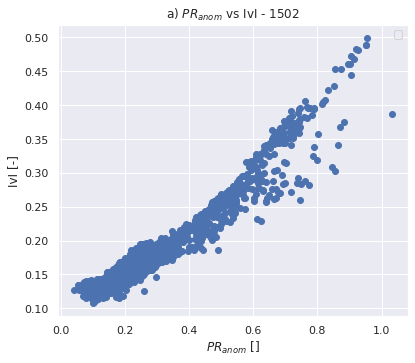

In [26]:
fig = plt.figure(figsize=(6,5))

#####################################################
# show skill as function of var. perturbation
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.14, right=0.95,
           bottom=0.12, top=0.93,
           wspace=0.25, hspace=0.20)
for re in [1]:
    sRegion=DW_Regions[re]
    sRegion=sRegion.replace('/','-')
    SaveStats=sDataDir+sRegion+'_'+YYYY_stamp+'-'+sMonths+'.npz'
    try:
        DATA=np.load(SaveStats, allow_pickle=True)
    except:
        print('    Missing: '+SaveStats)
        continue
    SkillScores_All=DATA['SkillScores_All']
    VARS=np.copy(VarsFullName)
    AUC = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('PRanom')]
    APR = SkillScores_All[:,:,:,:,:,:,list(Metrics).index('InterVSIntra')]
    
#     APR = np.squeeze(SkillScores_All[:,:,:,:,:,:,list(Metrics).index('APR')])
#     PEX = np.abs(1-np.squeeze(SkillScores_All[:,:,:,:,:,:,list(Metrics).index('PEX')]))
    PSS = np.abs(1-np.squeeze(SkillScores_All[:,:,:,:,:,:,list(Metrics).index('PSS')]))
    MRD = np.squeeze(SkillScores_All[:,:,:,:,:,:,list(Metrics).index('MRD')])
    MRR = np.squeeze(SkillScores_All[:,:,:,:,:,:,list(Metrics).index('MRR')])
    
#     ax2 = plt.subplot(gs2[0,0])
#     ax2.scatter(AUC[:,:,:],PEX[:,:,:], label = '4 extremes')
# #     ax2.scatter(AUC[:,2,:],PEX[:,2,:], color='r', alpha=0.5, label = '30 extremes')
#     plt.legend()
#     plt.title('a) AUC vs. PEX')
#     ax2.set_xlabel('AUC [-]')
#     ax2.set_ylabel('PEX [%]')
    
    
#     ax2 = plt.subplot(gs2[0,1])
#     ax2.scatter(AUC[:,:,:],PSS[:,:,:], label = '4 extremes')
# #     ax2.scatter(AUC[:,2,:],PSS[:,2,:], color='r', alpha=0.5, label = '30 extremes')
#     plt.legend()
#     plt.title('b) AUC vs. PSS')
#     ax2.set_xlabel('AUC [-]')
#     ax2.set_ylabel('PSS [-]')
    
    ax2 = plt.subplot(gs2[0,0])
    ax2.scatter(AUC[:,:,:],APR[:,:,:]) #, label = '4 extremes')
#     ax2.scatter(AUC[:,2,:],APR[:,2,:], color='r', alpha=0.5, label = '30 extremes')
    plt.legend()
    plt.title('a) '+r'$PR_{anom}$ vs IvI - '+sRegion)
    ax2.set_xlabel(r'$PR_{anom}$ []')
    ax2.set_ylabel('IvI [-]')
    
sPlotFile=sPlotDir
sPlotName= 'Skill-Score-comparison_HandK_NEW.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

In [39]:
AUC.shape

(377, 1, 3, 1, 1, 2)